In [1]:
# Import Libraries and Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Set a standard seaborn color palette
sns.set_palette("colorblind")

# Load data
df = pd.read_csv('Data.csv')

# Drop first column 
df = df.iloc[:, 1:]

# Define mapping dictionaries for categorical columns
mappings = {
    'GENDER': {0: 'Male', 1: 'Female'},
    'EDUCATION': {0: 'Others', 1: 'Postgraduate', 2: 'Tertiary', 3: 'High School'},
    'MARITAL': {0: 'Others', 1: 'Single', 2: 'Married'},
    'RATING': {0: 'Good', 1: 'Bad'},
    'S': {-1: 'Prompt', 0: 'Min Sum', 1: 'One', 2: 'Two', 3: 'Three', 4: 'Four', 5: 'Five', 6: 'Six', 7: 'Seven', 8: 'Eight', 9: 'Nine'}
}

# Convert columns to categorical and apply mappings
for col, mapping in mappings.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)
    else:
        for s_col in df.columns[df.columns.str.startswith(col)]:
            df[s_col] = df[s_col].map(mapping)
            
df

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
0,210000.0,0.000,235822,Bad,Female,Postgraduate,Married,30.0,Min Sum,Min Sum,...,0,0,0,0,0,0,0,0,0,0
1,260000.0,10928.050,278481,Good,Male,Tertiary,Married,31.0,Min Sum,Min Sum,...,54074,46407,38874,31324,24031,2000,2000,2000,2000,72000
2,400000.0,65397.850,431993,Good,Male,High School,Single,51.0,Min Sum,Min Sum,...,343591,352484,338823,283288,185288,15000,14000,11500,8000,7000
3,20000.0,3695.300,22368,Good,Male,Tertiary,Single,58.0,Prompt,Two,...,21470,200,0,28740,1295,0,0,28740,1565,0
4,180000.0,68.250,166900,Good,Female,Tertiary,Single,42.0,Min Sum,Min Sum,...,1260,598,2056,4300,1802,598,2056,4300,1802,3691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18744,220000.0,7888.125,228256,Good,Male,Tertiary,Single,41.0,Min Sum,Prompt,...,8840,1369,5924,1759,1824,6643,5924,1759,1824,7022
18745,40000.0,9162.650,45002,Bad,Male,Tertiary,Married,47.0,Two,Three,...,54892,53415,51259,47151,46934,0,2000,0,3520,0
18746,420000.0,23089.325,430208,Good,Male,Postgraduate,Married,34.0,Min Sum,Min Sum,...,136721,140011,141695,144839,147954,7000,5500,5500,5600,5000
18747,310000.0,41820.275,339696,Good,Male,Tertiary,Single,39.0,Min Sum,Min Sum,...,237196,233854,219409,216540,210675,9218,10029,8049,8040,10059


In [2]:
# Calculate number of missing values 
missing_values = df.isnull().sum()

# Filter the missing_values
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
columns_with_missing_values

LIMIT        31
BALANCE      25
EDUCATION    13
MARITAL      38
AGE          27
dtype: int64

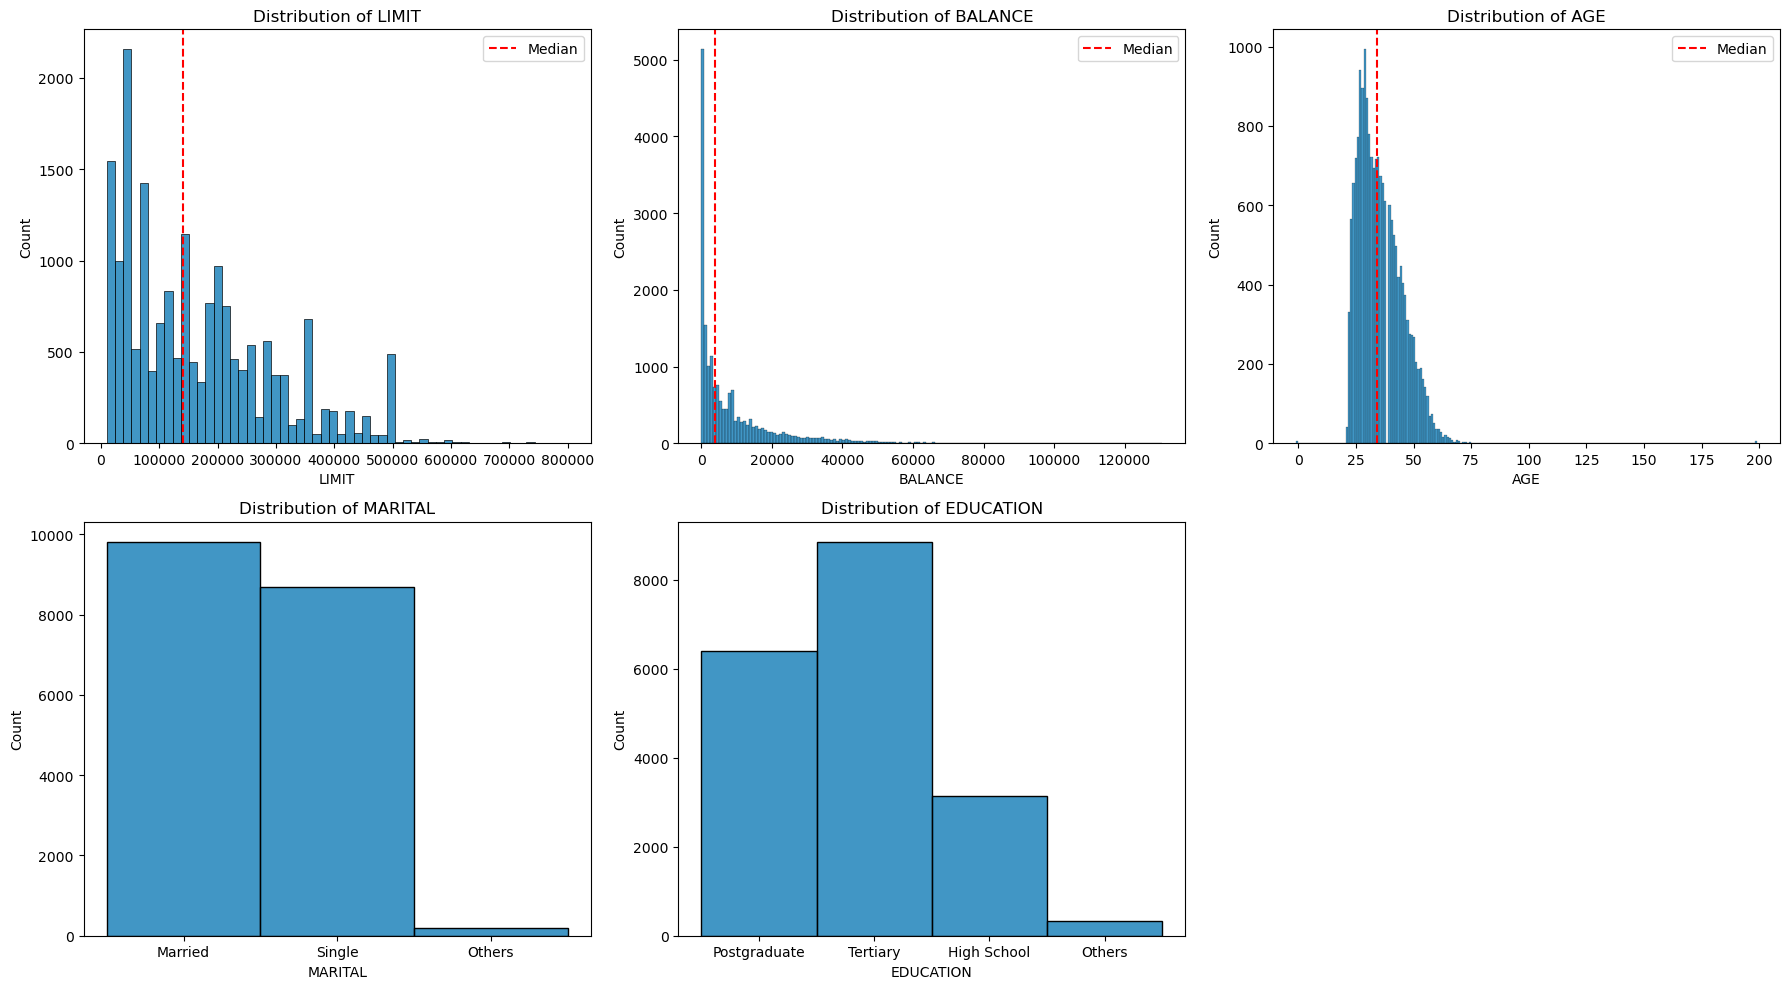

In [3]:
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Define columns to plot
columns = ['LIMIT', 'BALANCE', 'AGE', 'MARITAL', 'EDUCATION']

# Iterate over columns and plot them
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.histplot(df[column], kde=False, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {column}')
    if column in ['LIMIT', 'BALANCE', 'AGE']:
        axes[row, col].axvline(df[column].median(), color='red', linestyle='--', label='Median')
        axes[row, col].legend()

# Remove gridlines from subplots
for ax in axes.flatten():
    ax.grid(False)
    
# Hide empty subplots
for i in range(len(columns), axes.size):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [4]:
# Remove rows where 'Age' column has a value of 0, -1, or 100 and above
df = df[(df['AGE'] > 0) & (df['AGE'] < 100)].copy()

# Specify columns and corresponding fill methods
columns_to_fill = {
    'LIMIT': 'median',
    'BALANCE': 'median',
    'AGE': 'median',
    'MARITAL': 'mode',
    'EDUCATION': 'mode'
}

# Fill missing values in columns
for column, method in columns_to_fill.items():
    if method == 'median':
        df[column].fillna(df[column].median(), inplace=True)
    elif method == 'mode':
        df[column].fillna(df[column].mode()[0], inplace=True)

# Display number of columns with missing values
count_missing_values = df.isnull().sum().sum()
count_missing_values

0

In [5]:
# Define special characters
special_chars = "!@#$%^&"

# Iterate over each column 
for column in df.columns:
    # Iterate over each row in current column
    for index, value in df[column].items():
        # Check if value contains any special characters
        if any(char in special_chars for char in str(value)):
            print(f"Special characters found in column '{column}', row {index}: {value}")

Special characters found in column 'R3', row 1800: $0
Special characters found in column 'R3', row 1801: $2,620
Special characters found in column 'R3', row 1802: $6,000
Special characters found in column 'R3', row 1803: $2,200
Special characters found in column 'R3', row 1804: $390
Special characters found in column 'R3', row 1805: $2,688
Special characters found in column 'R3', row 1806: $13,069
Special characters found in column 'R3', row 1807: $7,000
Special characters found in column 'R3', row 1808: $5,000
Special characters found in column 'R3', row 1809: $2,089


In [6]:
# Remove special characters ('$' and ',') and spaces from column 'R3'
df['R3'] = df['R3'].str.replace("$", "").str.replace(",", "").str.replace(" ", "")

In [7]:
# Identify categorical variables
categorical_variables = df.select_dtypes(include=['object', 'category']).columns

# Check for categorical variables that need encoding
if categorical_variables.empty:
    print("No categorical variables need encoding.")
else:
    print("The following categorical variables need encoding:\n" + "\n".join(categorical_variables))

The following categorical variables need encoding:
RATING
GENDER
EDUCATION
MARITAL
S1
S2
S3
S4
S5
R3


In [8]:
# Convert 'R3' column to the same data type as 'R1', 'R2', 'R4', and 'R5'
df['R3'] = df['R3'].astype(df['R1'].dtype)

In [9]:
# Create Descriptive Stats table 
Descriptive_Stats = df.describe(include='all').round(2)

# Separate columns into categorical and numerical groups
categorical_columns = Descriptive_Stats.select_dtypes(include=['object']).columns
numeric_columns = Descriptive_Stats.select_dtypes(exclude=['object']).columns

# Order columns (categorical followed by numerical)
ordered_columns = list(categorical_columns) + list(numeric_columns)
Descriptive_Stats = Descriptive_Stats.reindex(ordered_columns, axis=1)

# Transpose Descriptive Stats table 
Descriptive_Stats = Descriptive_Stats.transpose()

Descriptive_Stats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RATING,18712,2,Good,14613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GENDER,18712,2,Female,11584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDUCATION,18712,4,Tertiary,8856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MARITAL,18712,3,Married,9843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S1,18712,9,Min Sum,12335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S2,18712,10,Min Sum,12572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S3,18712,9,Min Sum,12923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S4,18712,8,Min Sum,13576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S5,18712,8,Min Sum,13614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LIMIT,18712.0,NaN,NaN,NaN,168359.54,129362.6,10000.0,50000.0,140000.0,240000.0,800000.0


In [10]:
# Apply Min-Max scaling to numerical columns
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
0,0.253165,0.000000,0.251235,Bad,Female,Postgraduate,Married,0.152542,Min Sum,Min Sum,...,0.085748,0.155345,0.084410,0.089884,0.288734,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.316456,0.083617,0.298695,Good,Male,Tertiary,Married,0.169492,Min Sum,Min Sum,...,0.152198,0.201186,0.134763,0.124501,0.321925,0.001630,0.002250,0.003221,0.004689,0.136585
2,0.493671,0.500395,0.469483,Good,Male,High School,Single,0.508475,Min Sum,Min Sum,...,0.507981,0.503529,0.523282,0.402953,0.544648,0.012224,0.015747,0.018519,0.018756,0.013279
3,0.012658,0.028275,0.013760,Good,Male,Tertiary,Single,0.627119,Prompt,Two,...,0.112132,0.155543,0.084410,0.121646,0.290523,0.000000,0.000000,0.046280,0.003669,0.000000
4,0.215190,0.000522,0.174557,Good,Female,Tertiary,Single,0.355932,Min Sum,Min Sum,...,0.087296,0.155936,0.087073,0.094636,0.291223,0.000487,0.002313,0.006924,0.004225,0.007002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18744,0.265823,0.060356,0.242818,Good,Male,Tertiary,Single,0.338983,Min Sum,Prompt,...,0.096611,0.156698,0.092083,0.091828,0.291253,0.005414,0.006663,0.002833,0.004276,0.013321
18745,0.037975,0.070108,0.038941,Bad,Male,Tertiary,Married,0.440678,Two,Three,...,0.153204,0.208109,0.150805,0.141992,0.353558,0.000000,0.002250,0.000000,0.008253,0.000000
18746,0.518987,0.176669,0.467497,Good,Male,Postgraduate,Married,0.220339,Min Sum,Min Sum,...,0.253762,0.293648,0.267945,0.249950,0.493083,0.005705,0.006186,0.008857,0.013129,0.009485
18747,0.379747,0.319990,0.366799,Good,Male,Tertiary,Single,0.305085,Min Sum,Min Sum,...,0.377234,0.386347,0.368607,0.329188,0.579711,0.007512,0.011281,0.012961,0.018850,0.019082


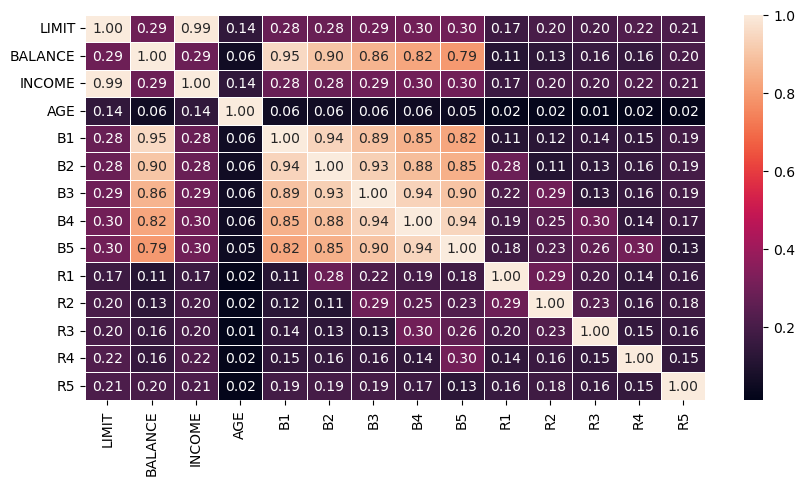

Pairs of variables with correlation greater than 0.7:
('B1', 'B2')
('B1', 'B3')
('B1', 'B4')
('B1', 'B5')
('B1', 'BALANCE')
('B2', 'B3')
('B2', 'B4')
('B2', 'B5')
('B2', 'BALANCE')
('B3', 'B4')
('B3', 'B5')
('B3', 'BALANCE')
('B4', 'B5')
('B4', 'BALANCE')
('B5', 'BALANCE')
('INCOME', 'LIMIT')


In [11]:
def plot_corr_and_print_highly_correlated(df):
    # Create a correlation matrix
    corr_matrix = df.select_dtypes(include='number').corr()

    # Plot heatmap
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5)
    plt.show()

    # Create a mask for correlations greater than 0.7
    high_corr = corr_matrix[corr_matrix > 0.7]

    # Get pairs of highly correlated variables
    high_corr_pairs = [(i, j) for i in high_corr.columns for j in high_corr.index if (high_corr[i][j] > 0.7) & (i != j)]

    # Sort each pair and remove duplicates
    high_corr_pairs = list(set([tuple(sorted(pair)) for pair in high_corr_pairs]))

    # Sort the pairs alphabetically
    high_corr_pairs = sorted(high_corr_pairs)

    print("Pairs of variables with correlation greater than 0.7:")
    for pair in high_corr_pairs:
        print(pair)
        
# Call the function
plot_corr_and_print_highly_correlated(df)


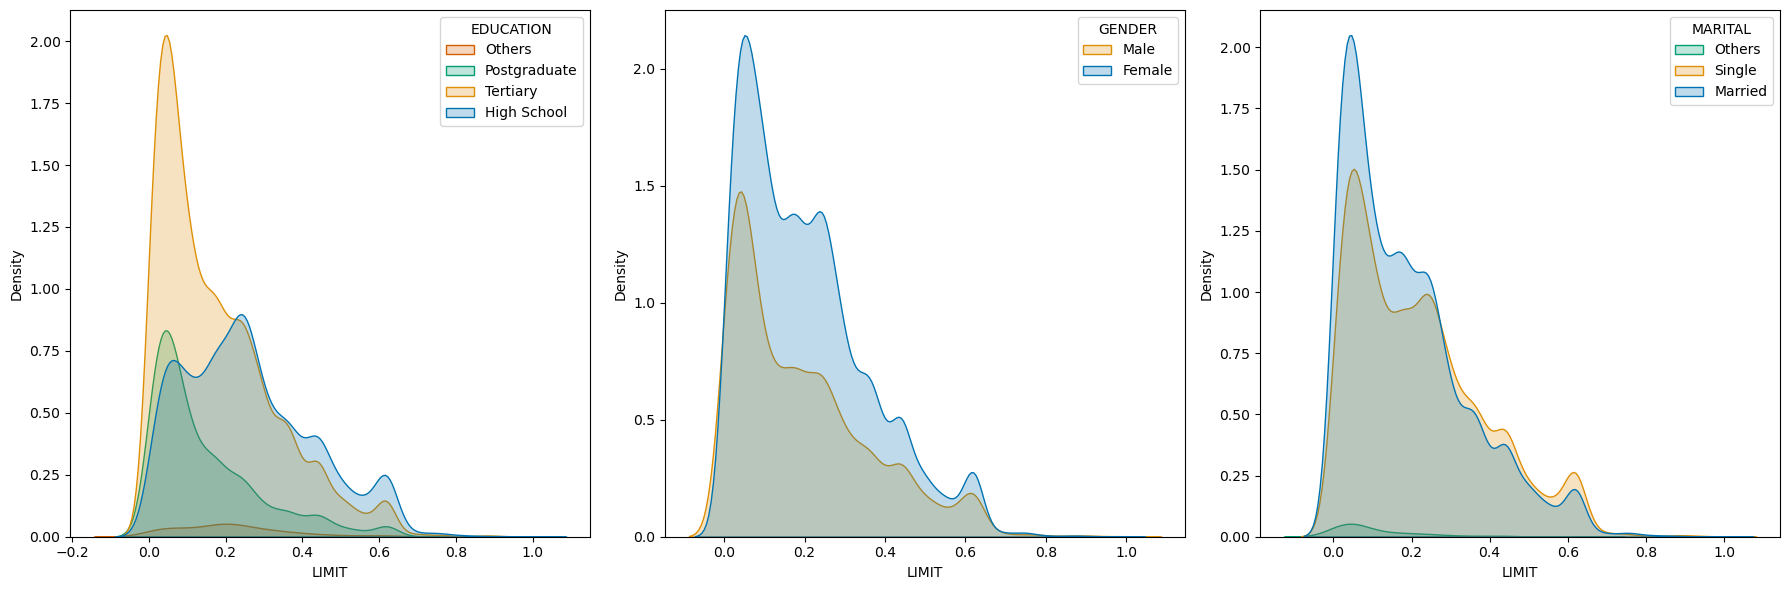

In [12]:
# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define variables
plot_data = [('EDUCATION', 'Education Level', ['Others', 'Postgraduate', 'Tertiary', 'High School']),
             ('GENDER', 'Gender', ['Male', 'Female']),
             ('MARITAL', 'Marital Status', ['Others', 'Single', 'Married'])]

# Plot each density plot in a subplot
for ax, (variable, title, labels) in zip(axes, plot_data):
    sns.kdeplot(data=df, x='LIMIT', hue=variable, fill=True, ax=ax)
    ax.set(xlabel='LIMIT', ylabel='Density')
    ax.legend(title=variable, labels=labels)

plt.tight_layout()
plt.show()

C:\Users\RR\AppData\Local\Temp\ipykernel_11192\4025063317.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\RR\AppData\Local\Temp\ipykernel_11192\4025063317.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


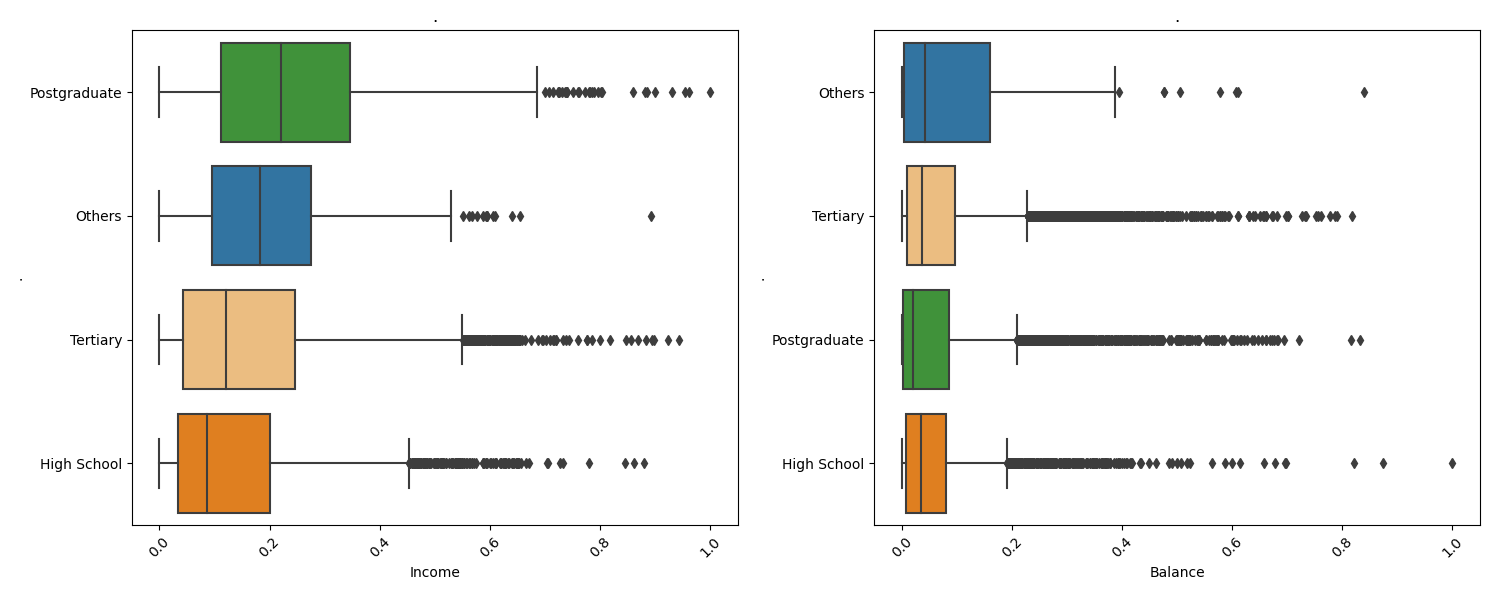

In [13]:
# Define plot data
plot_data = [
    {'column_x': 'INCOME', 'column_y': 'EDUCATION', 'data': 'INCOME', 'title': '.'},
    {'column_x': 'BALANCE', 'column_y': 'EDUCATION', 'data': 'BALANCE', 'title': '.'}
]

# Custom color palette for education levels 
custom_palette = {
    'Others': '#1f78b4',        
    'Postgraduate': '#33a02c',  
    'Tertiary': '#fdbf6f',     
    'High School': '#ff7f00'   
}

# Create subplots
fig, axes = plt.subplots(1, len(plot_data), figsize=(15, 6))

for i, plot_info in enumerate(plot_data):
    # Calculate mean values and sort by order
    mean_values = df.groupby(plot_info['column_y'])[plot_info['column_x']].mean().sort_values(ascending=False).index

    sns.boxplot(ax=axes[i], x=plot_info['column_x'], y=plot_info['column_y'],
                data=df, order=mean_values, palette=custom_palette)

    axes[i].set_xlabel(plot_info['data'].capitalize())
    axes[i].set_ylabel('.')
    axes[i].set_title(plot_info['title'])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].grid(False)

plt.tight_layout()
plt.show()

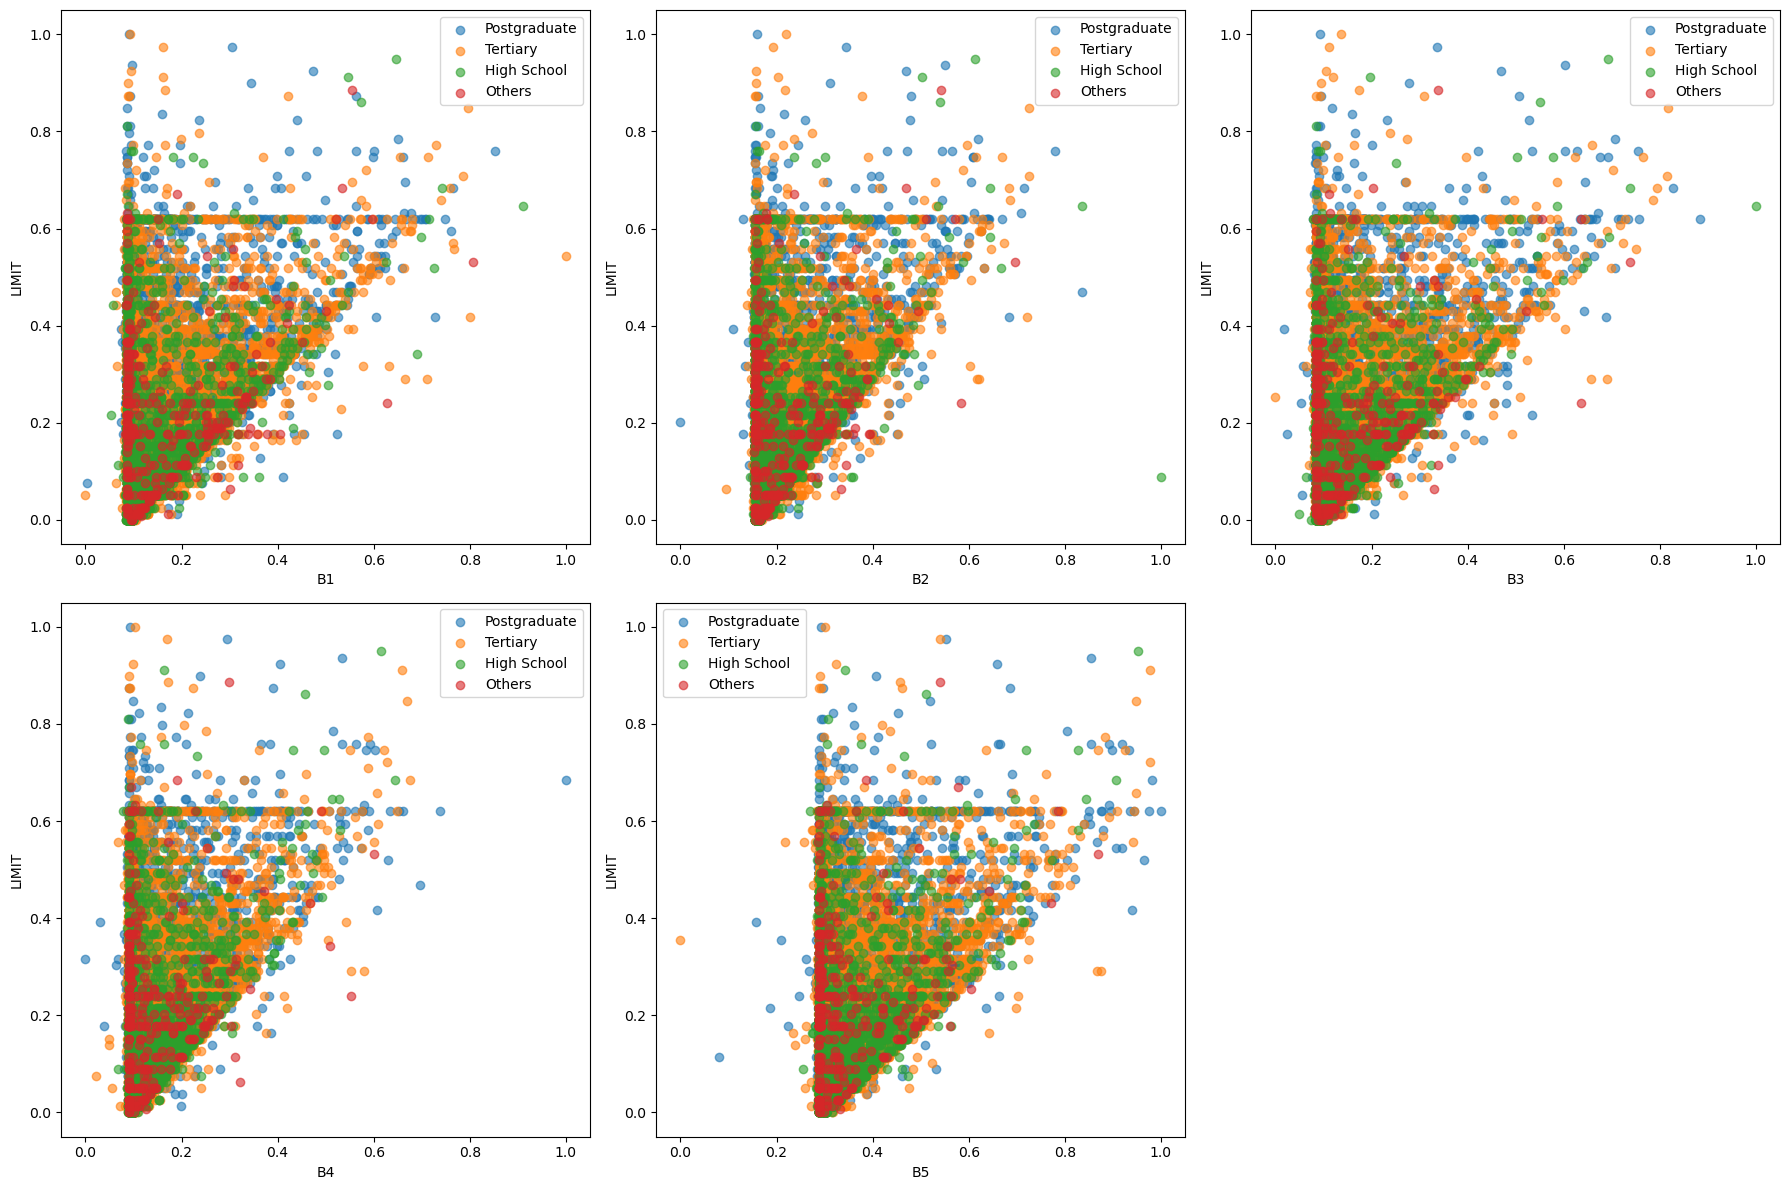

In [14]:
# Define education levels and corresponding colors
unique_education = df['EDUCATION'].unique()
colors = plt.cm.tab10.colors[:len(unique_education)]

# Define variables to plot
variables = ['B1', 'B2', 'B3', 'B4', 'B5']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plotting
for ax, variable in zip(axes, variables):
    for color, education in zip(colors, unique_education):
        data = df[df['EDUCATION'] == education]
        ax.scatter(data[variable], data['LIMIT'], color=color, label=education, alpha=0.6)
    ax.set_xlabel(variable)
    ax.set_ylabel('LIMIT')
    ax.legend()

# Hide empty subplots
for ax in axes[len(variables):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


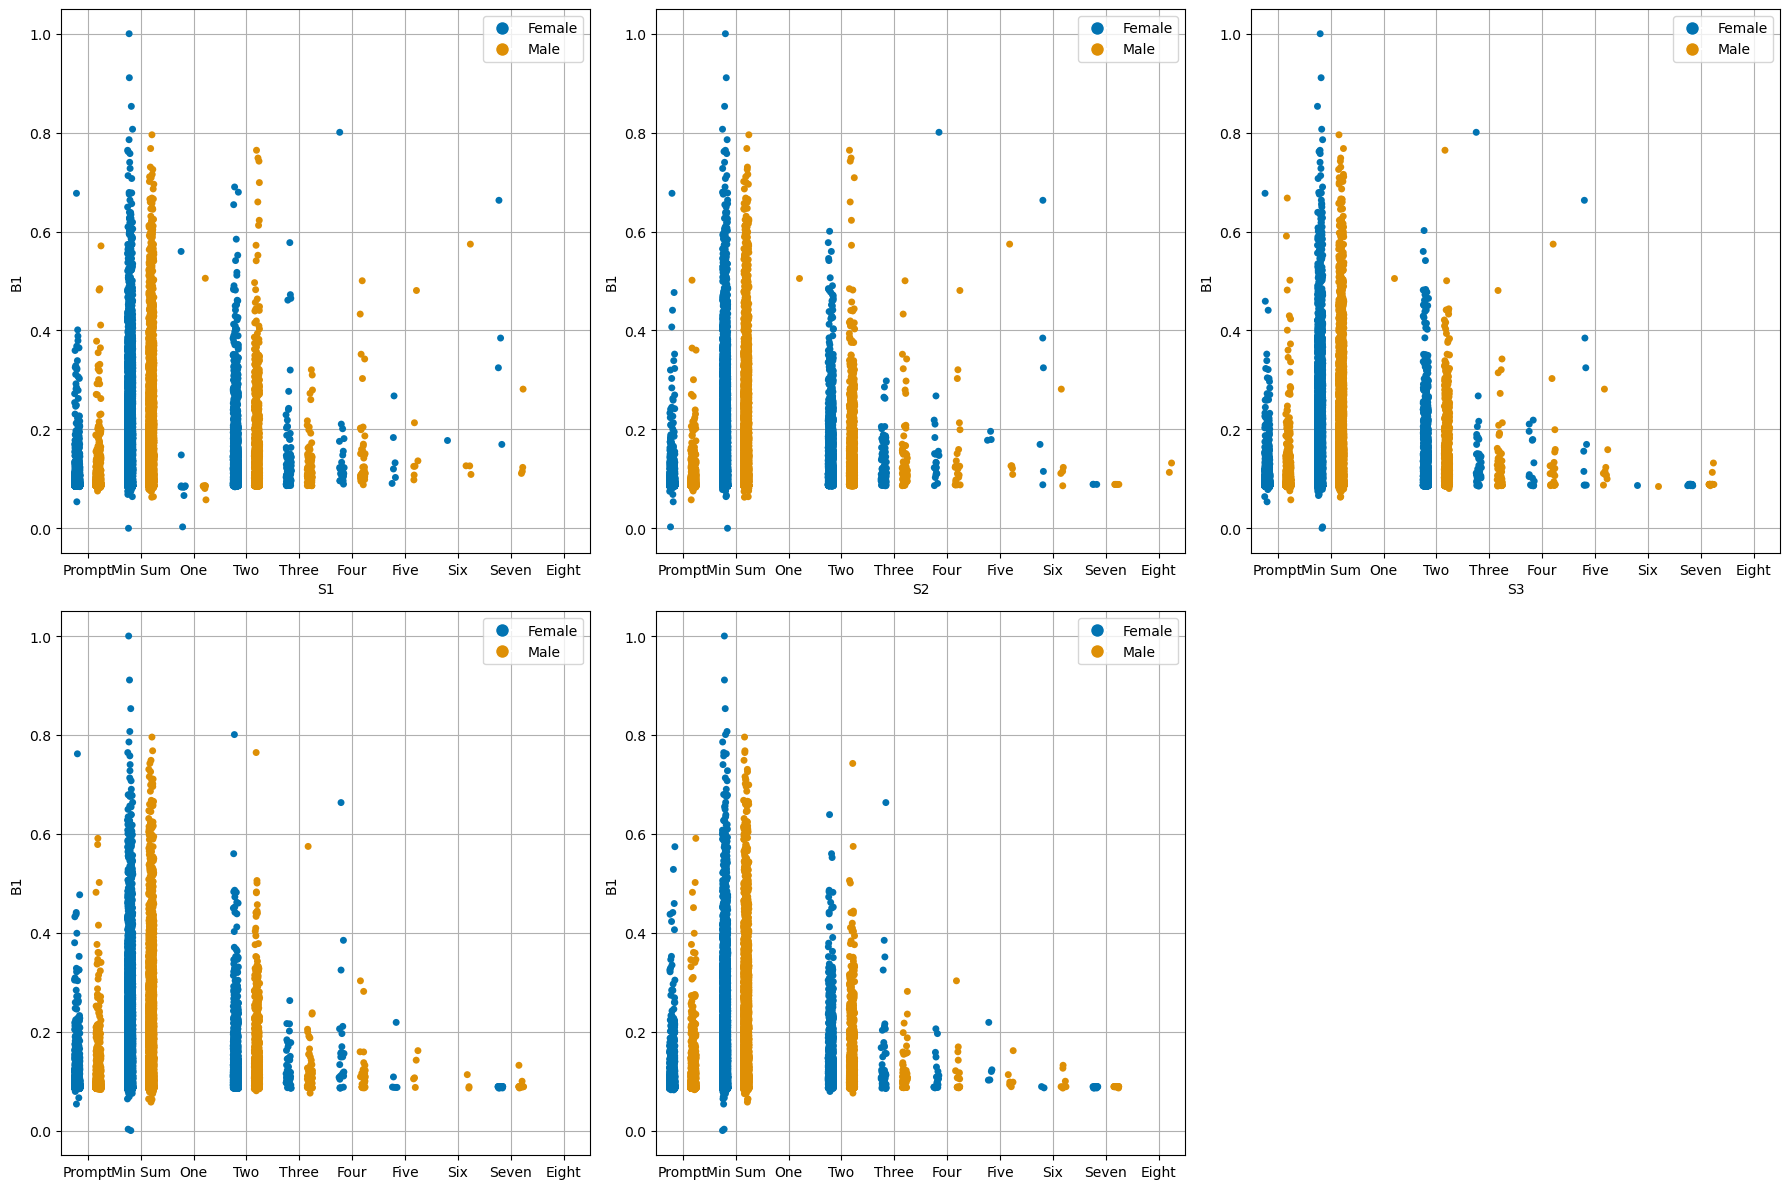

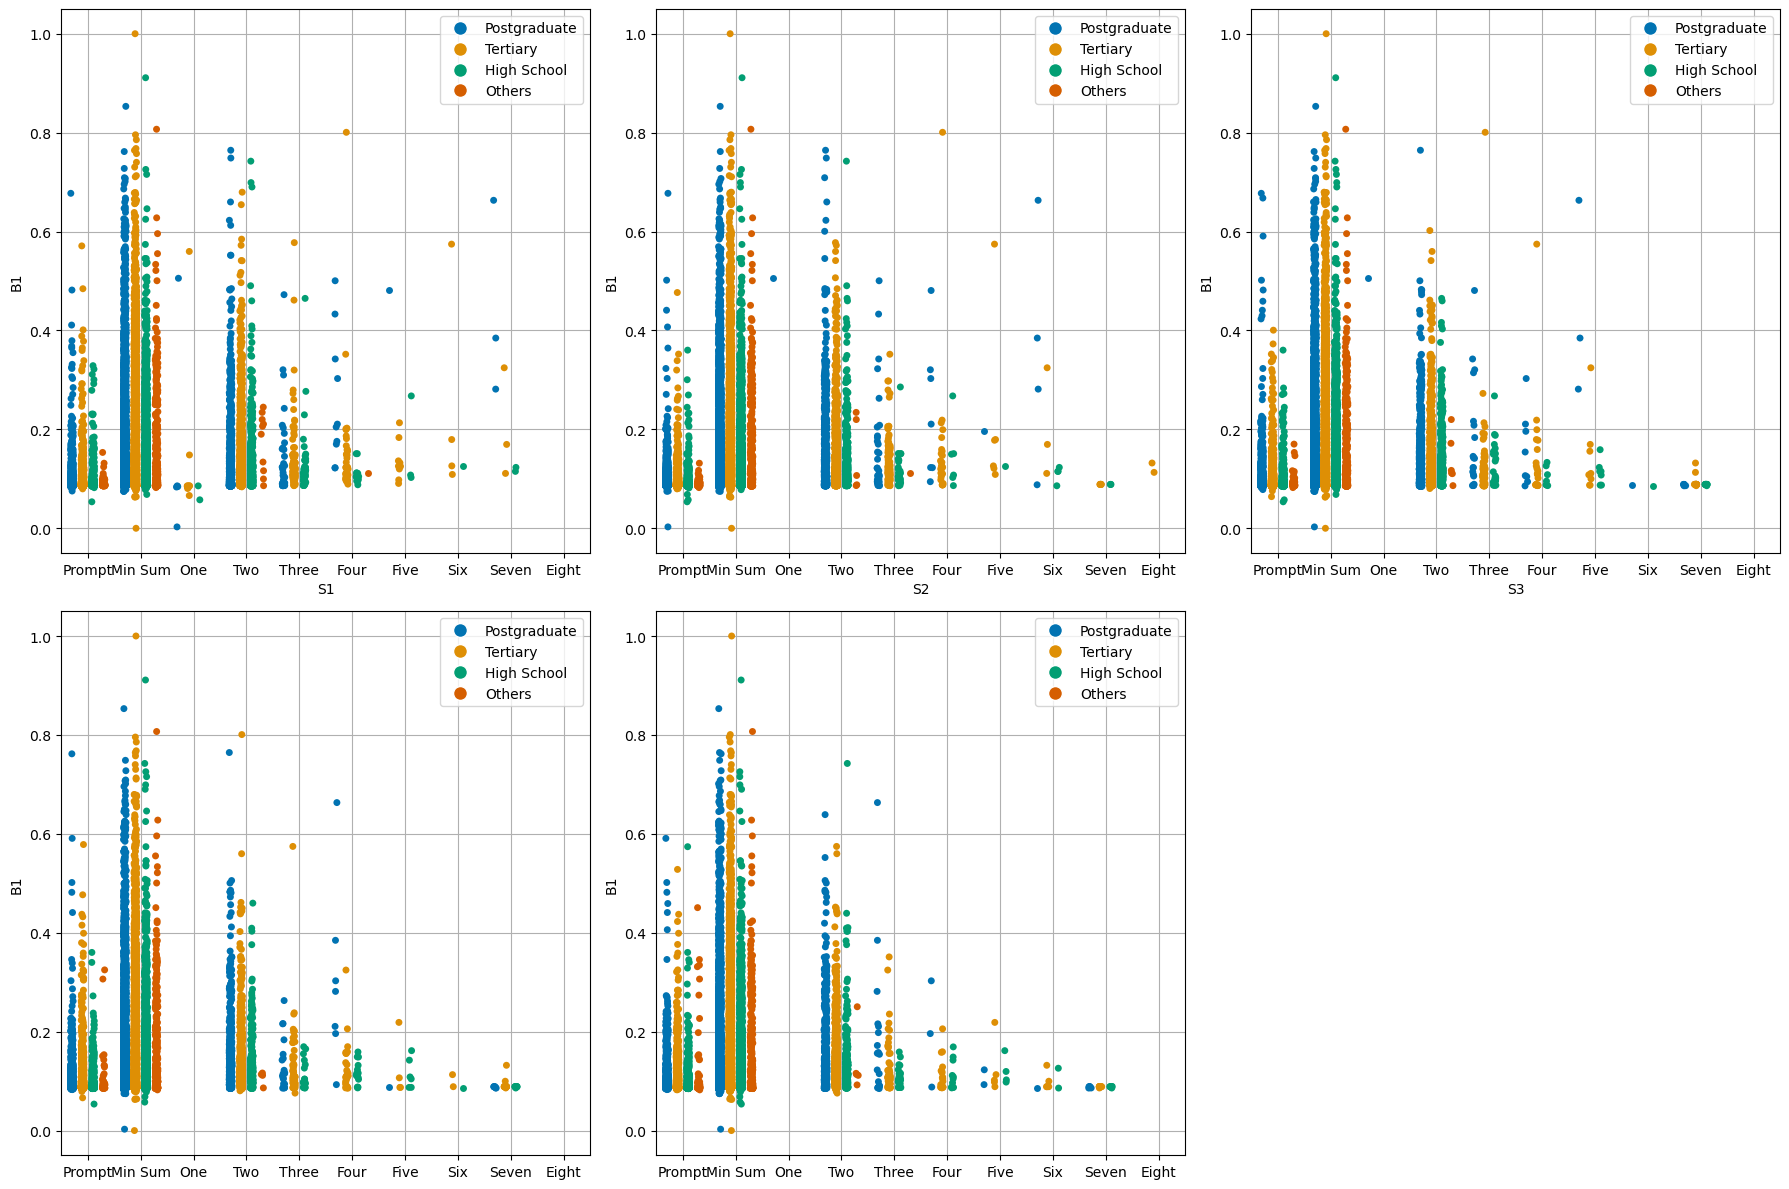

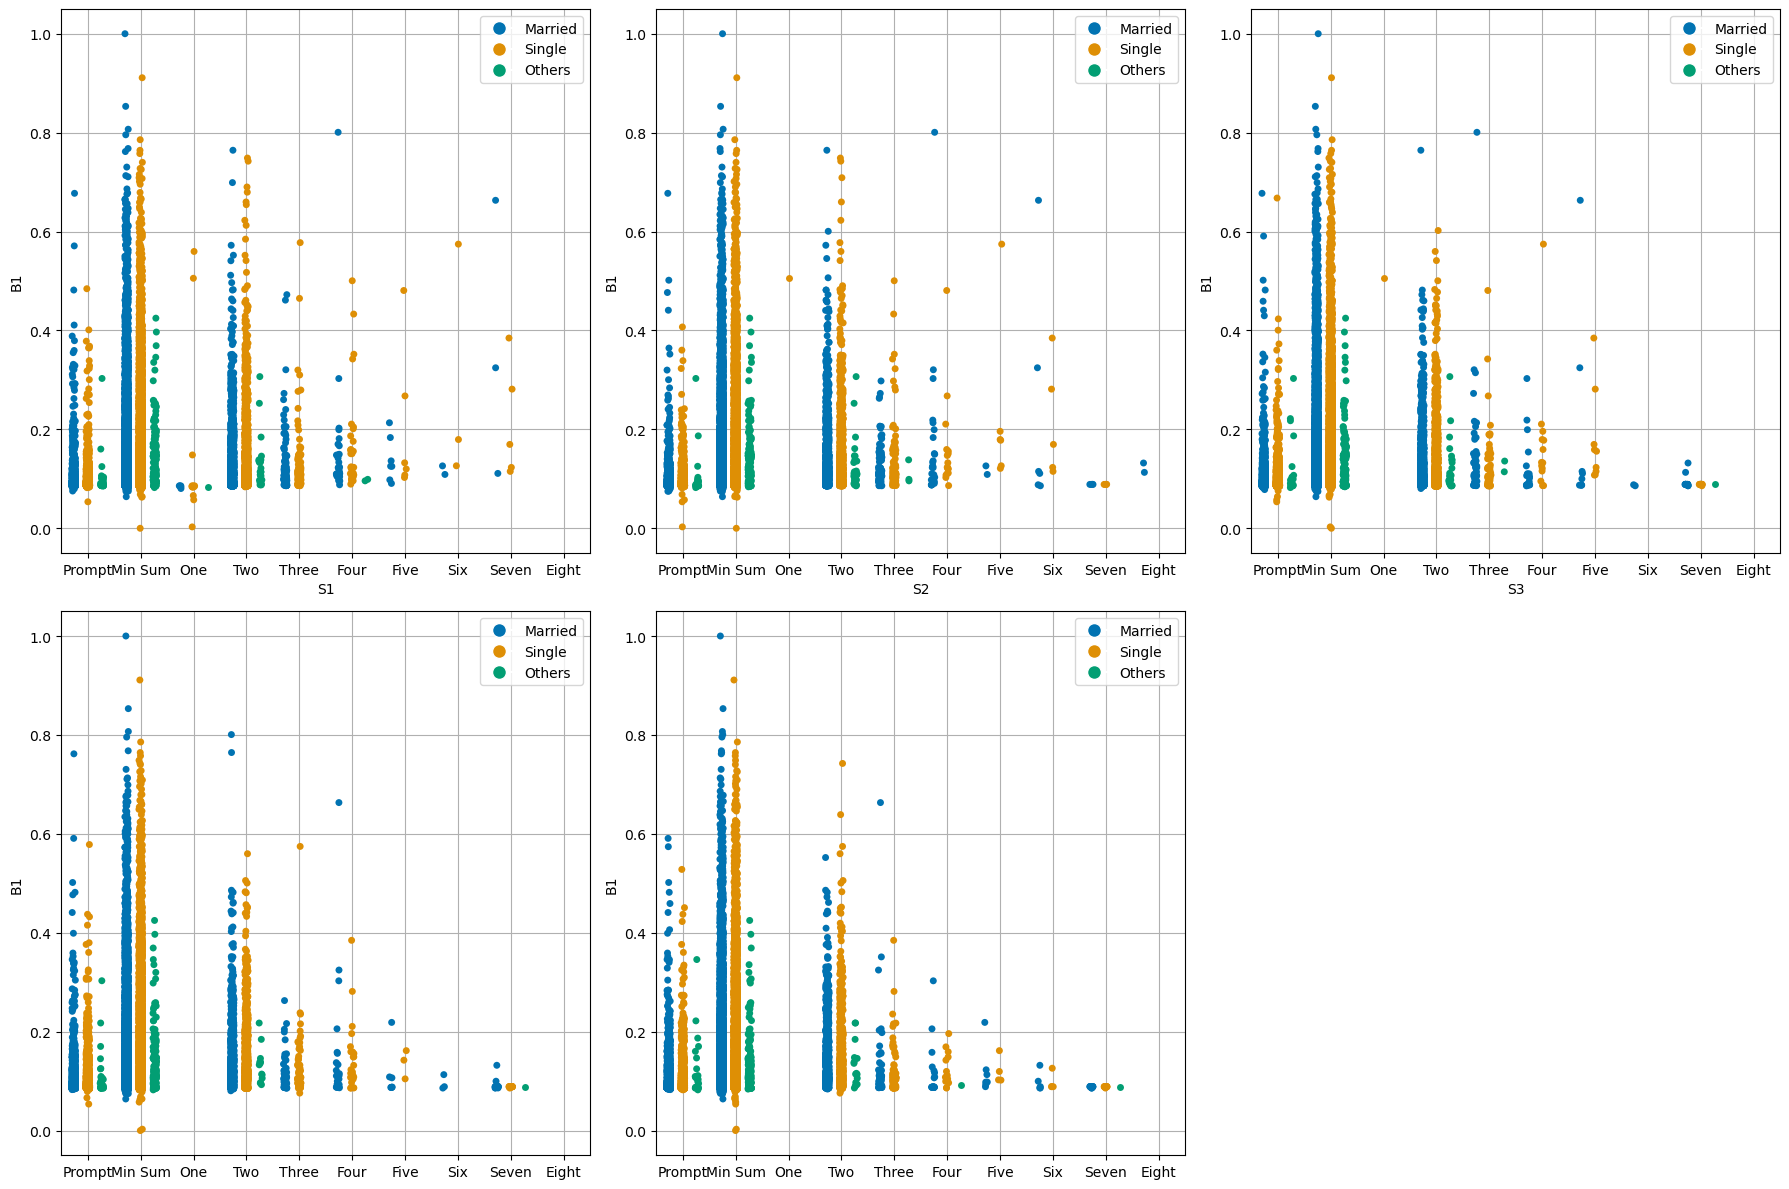

In [15]:
# Define variables to plot
variables = ['S1', 'S2', 'S3', 'S4', 'S5']

# Define the order of categories for each variable
variable_order = {
    'S1': ['Prompt', 'Min Sum', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight'],
    'S2': ['Prompt', 'Min Sum', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight'],
    'S3': ['Prompt', 'Min Sum', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight'],
    'S4': ['Prompt', 'Min Sum', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight'],
    'S5': ['Prompt', 'Min Sum', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight']
}

# Iterate through each hue
for hue in ['GENDER', 'EDUCATION', 'MARITAL']:
    # Get the colorblind palette
    hue_colors = sns.color_palette("colorblind", len(df[hue].unique()))

    # Create subplots for the current hue
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Plotting
    for ax, variable in zip(axes, variables):
        # Ensure df contains the current hue column
        if hue in df.columns:
            sns.stripplot(x=df[variable], y=df['B1'], hue=df[hue], ax=ax, palette=hue_colors, order=variable_order[variable], jitter=True, dodge=True)
            ax.set_xlabel(variable if variable not in variables[3:] else '')
            ax.set_ylabel('B1')
            ax.grid(True)

            # Create a legend for the current hue
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in hue_colors]
            ax.legend(handles, df[hue].unique(), loc='upper right')
        else:
            print(f"Warning: DataFrame does not contain column '{hue.upper()}'")

    # Hide empty subplots
    for ax in axes[len(variables):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()


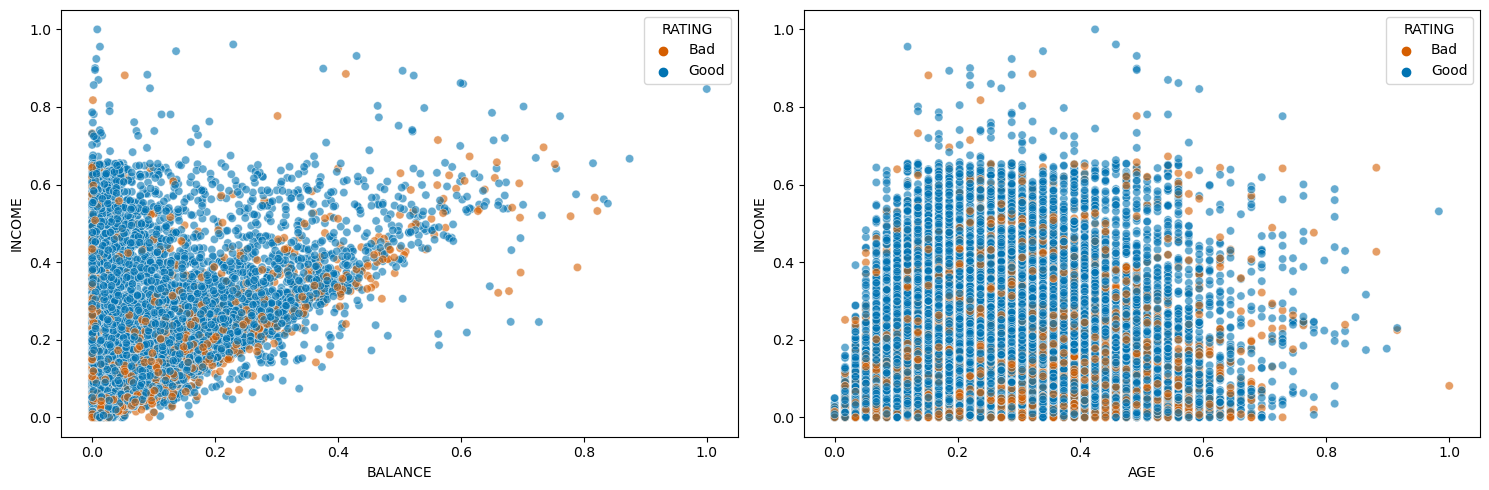

In [16]:
# Define variables 
variables = ['BALANCE', 'AGE']

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plotting
for i, var in enumerate(variables):
    ax = axes[i]
    sns.scatterplot(data=df, x=var, y='INCOME', hue='RATING', palette={'Good': sns.color_palette()[0], 'Bad': sns.color_palette()[3]}, alpha=0.6, ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel('INCOME')
    ax.legend(title='RATING')

plt.tight_layout()
plt.show()


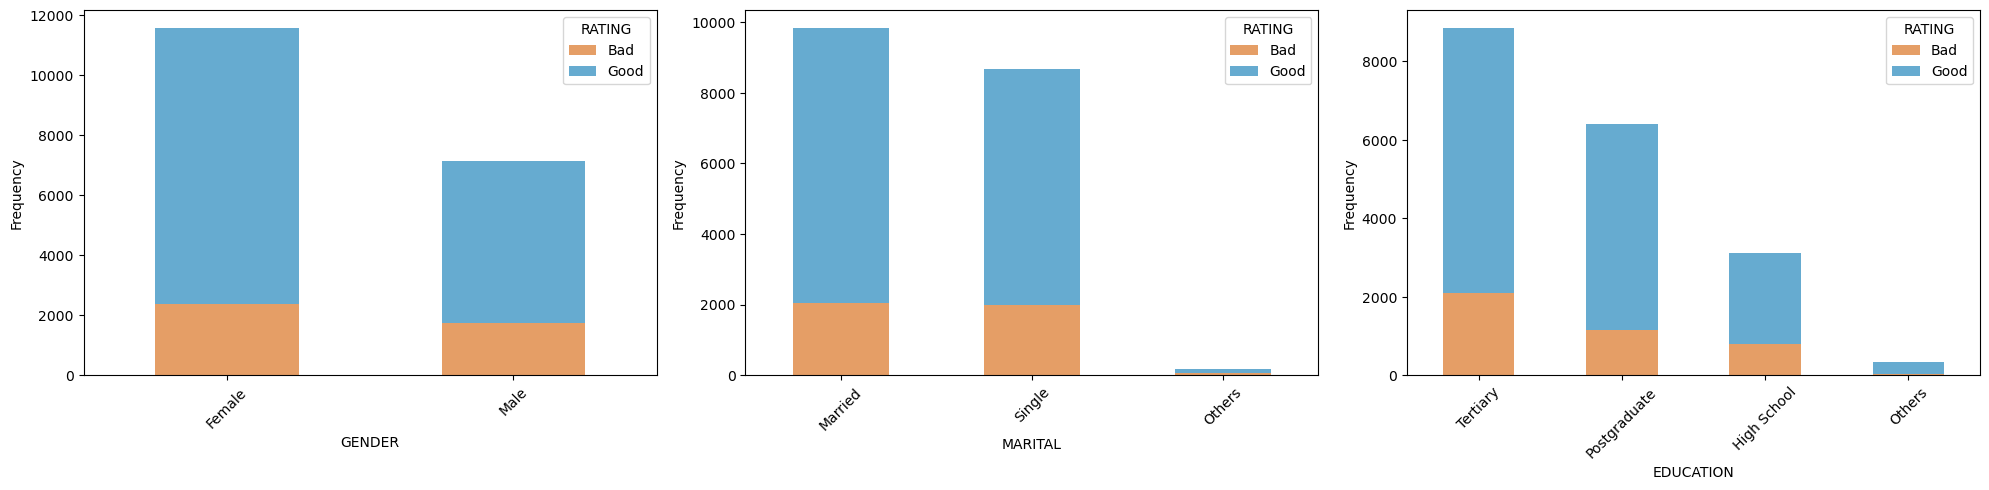

In [17]:
# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Calculate frequencies for each rating category for GENDER, MARITAL, and EDUCATION
for ax, category in zip(axes, ['GENDER', 'MARITAL', 'EDUCATION']):
    # Count the occurrences of each category in the RATING column
    education_counts = df[df['RATING'].isin(['Good', 'Bad'])].groupby([category, 'RATING']).size().unstack(fill_value=0)

    # Plotting with sorted frequencies
    education_counts.sort_values(by='Good', ascending=False).plot(kind='bar', stacked=True, ax=ax, color={'Good': sns.color_palette()[0], 'Bad': sns.color_palette()[3]}, alpha=0.6)
    ax.set_xlabel(category)
    ax.set_ylabel('Frequency')
    ax.legend(title='RATING')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

In [18]:
# Revert to original scale
df[numeric_columns] = scaler.inverse_transform(df[numeric_columns])
df

,LIMIT,BALANCE,INCOME,RATING,GENDER,EDUCATION,MARITAL,AGE,S1,S2,...,B1,B2,B3,B4,B5,R1,R2,R3,R4,R5
0,210000.0,0.000,235822.0,Bad,Female,Postgraduate,Married,30.0,Min Sum,Min Sum,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,260000.0,10928.050,278481.0,Good,Male,Tertiary,Married,31.0,Min Sum,Min Sum,...,54074.0,46407.0,38874.0,31324.0,24031.0,2000.0,2000.0,2000.0,2000.0,72000.0
2,400000.0,65397.850,431993.0,Good,Male,High School,Single,51.0,Min Sum,Min Sum,...,343591.0,352484.0,338823.0,283288.0,185288.0,15000.0,14000.0,11500.0,8000.0,7000.0
3,20000.0,3695.300,22368.0,Good,Male,Tertiary,Single,58.0,Prompt,Two,...,21470.0,200.0,0.0,28740.0,1295.0,0.0,0.0,28740.0,1565.0,0.0
4,180000.0,68.250,166900.0,Good,Female,Tertiary,Single,42.0,Min Sum,Min Sum,...,1260.0,598.0,2056.0,4300.0,1802.0,598.0,2056.0,4300.0,1802.0,3691.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18744,220000.0,7888.125,228256.0,Good,Male,Tertiary,Single,41.0,Min Sum,Prompt,...,8840.0,1369.0,5924.0,1759.0,1824.0,6643.0,5924.0,1759.0,1824.0,7022.0
18745,40000.0,9162.650,45002.0,Bad,Male,Tertiary,Married,47.0,Two,Three,...,54892.0,53415.0,51259.0,47151.0,46934.0,0.0,2000.0,0.0,3520.0,0.0
18746,420000.0,23089.325,430208.0,Good,Male,Postgraduate,Married,34.0,Min Sum,Min Sum,...,136721.0,140011.0,141695.0,144839.0,147954.0,7000.0,5500.0,5500.0,5600.0,5000.0
18747,310000.0,41820.275,339696.0,Good,Male,Tertiary,Single,39.0,Min Sum,Min Sum,...,237196.0,233854.0,219409.0,216540.0,210675.0,9218.0,10029.0,8049.0,8040.0,10059.0


In [19]:
# Dummy columns
df = pd.get_dummies(df, columns=['RATING','GENDER','EDUCATION','MARITAL','S1','S2','S3','S4','S5'])

# Convert boolean columns to integers (1 and 0)
df[df.select_dtypes(include=bool).columns] = df.select_dtypes(include=bool).astype(int)
df

,LIMIT,BALANCE,INCOME,AGE,B1,B2,B3,B4,B5,R1,...,S4_Three,S4_Two,S5_Five,S5_Four,S5_Min Sum,S5_Prompt,S5_Seven,S5_Six,S5_Three,S5_Two
0,210000.0,0.000,235822.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,260000.0,10928.050,278481.0,31.0,54074.0,46407.0,38874.0,31324.0,24031.0,2000.0,...,0,0,0,0,1,0,0,0,0,0
2,400000.0,65397.850,431993.0,51.0,343591.0,352484.0,338823.0,283288.0,185288.0,15000.0,...,0,0,0,0,1,0,0,0,0,0
3,20000.0,3695.300,22368.0,58.0,21470.0,200.0,0.0,28740.0,1295.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,180000.0,68.250,166900.0,42.0,1260.0,598.0,2056.0,4300.0,1802.0,598.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18744,220000.0,7888.125,228256.0,41.0,8840.0,1369.0,5924.0,1759.0,1824.0,6643.0,...,0,0,0,0,1,0,0,0,0,0
18745,40000.0,9162.650,45002.0,47.0,54892.0,53415.0,51259.0,47151.0,46934.0,0.0,...,0,1,0,0,0,0,0,0,0,1
18746,420000.0,23089.325,430208.0,34.0,136721.0,140011.0,141695.0,144839.0,147954.0,7000.0,...,0,0,0,0,1,0,0,0,0,0
18747,310000.0,41820.275,339696.0,39.0,237196.0,233854.0,219409.0,216540.0,210675.0,9218.0,...,0,0,0,0,1,0,0,0,0,0


In [20]:
# Identify numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# IQR function to identify outliers
def identify_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

# Apply the function
outliers = df[numeric_columns].apply(identify_outliers_iqr)

# Keep a copy of original DataFrame
df_with_outliers = df.copy()

# Remove outliers
df = df[~outliers.any(axis=1)]

# Get the rows of outliers that have been removed
removed_outliers = df_with_outliers[outliers.any(axis=1)]

# Print the number of rows of outliers that have been removed
print(f"Number of rows of outliers removed: {len(removed_outliers)}")

Number of rows of outliers removed: 6236


In [21]:
# Get list of numerical predictor variables
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
predictors = df[numeric_columns].drop(columns='B1')

# Add a constant to predictor variables
predictors = sm.add_constant(predictors)

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = predictors.columns
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Remove variable with the highest VIF
while vif['VIF'].max() > 5:
    # Identify variable with the highest VIF
    max_vif_variable = vif.loc[vif['VIF'].idxmax(), 'Variable']
    
    # If variable with the highest VIF is 'const', skip it
    if max_vif_variable == 'const':
        vif = vif.drop(vif['VIF'].idxmax())
        continue
    
    # Drop variable with the highest VIF
    predictors = predictors.drop(columns=max_vif_variable)
    
    # Recalculate VIF
    vif = pd.DataFrame()
    vif["Variable"] = predictors.columns
    vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

# Print VIF values
vif

,Variable,VIF
1,BALANCE,2.807915
2,INCOME,1.065618
3,AGE,1.012101
4,B5,3.368450
5,R1,1.440305
6,R2,1.446017
7,R3,1.513133
8,R4,1.623042
9,R5,1.510075


In [22]:
# Define independent variables (X)
X = sm.add_constant(df.drop(columns=['B1']))

# Define dependent variable (Y)
y = df['B1']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Fit the OLS (Ordinary Least Squares) model on training data
model = sm.OLS(y_train, X_train).fit()

# Iterate through the p-values and remove variables with p-value > 0.05, excluding the constant term
while model.pvalues.drop('const').max() > 0.05:
    # Find the variable with the highest p-value (excluding the constant term)
    max_pvalue_index = model.pvalues.drop('const').idxmax()
    # Remove the variable from X_train and X_test
    X_train = X_train.drop(columns=[max_pvalue_index])
    X_test = X_test.drop(columns=[max_pvalue_index])
    # Fit the model again with the updated X_train
    model = sm.OLS(y_train, X_train).fit()

# Make predictions on training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate Root Mean Squared Error (RMSE) for training and testing sets
rmse_train = np.sqrt(np.mean((y_train - y_train_pred)**2))
rmse_test = np.sqrt(np.mean((y_test - y_test_pred)**2))

# Print the RMSE 
print("Train RMSE:", round(rmse_train, 2))
print("Test RMSE:", round(rmse_train, 2))

# Print model summary
model.summary()

Train RMSE: 7638.74
Test RMSE: 7638.74


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     B1   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 1.155e+04
Date:                Mon, 11 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:35:09   Log-Likelihood:                -90473.
No. Observations:                8733   AIC:                         1.810e+05
Df Residuals:                    8718   BIC:                         1.811e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             471.3061    262.462      1.796      0.073     -43.182     985.794
BALANCE             2.4420      0.033     74.916      0.000       2.378       2.506
B2                  0.6243      0.011     57.349      0.000       0.603       0.646
B3                 -0.0249      0.012     -2.020      0.043      -0.049      -0.001
B5                 -0.0165      0.008     -2.082      0.037      -0.032      -0.001
R1                 -0.2711      0.051     -5.352      0.000      -0.370      -0.172
R2                  0.1542      0.050      3.100      0.002       0.057       0.252
MARITAL_Married  -451.4526    222.695     -2.027      0.043    -887.988     -14.917
MARITAL_Others   1419.7739    589.536      2.408      0.016     264.144    2575.404
MARITAL_Single   -497.0152    225.273     -2.206      0.027    -938.603     -55.427
S1_Min Sum       1600.0668    294.249      5.438      0.000    1023.268    2176.865
S1_One          -1.837e+04   3437.846     -5.342      0.000   -2.51e+04   -1.16e+04
S1_Prompt        2369.0671    382.368      6.196      0.000    1619.535    3118.599
S2_Min Sum      -1634.1932    342.438     -4.772      0.000   -2305.453    -962.933
S2_Prompt       -1505.1191    406.267     -3.705      0.000   -2301.499    -708.739
S3_Min Sum        612.9408    261.658      2.343      0.019     100.029    1125.853
==============================================================================
Omnibus:                     7278.255   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           567312.634
Skew:                           3.520   Prob(JB):                         0.00
Kurtosis:                      41.853   Cond. No.                     9.13e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.79e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
# Define columns for dummy encoding
dummy_cols = ['RATING','GENDER','EDUCATION','MARITAL','S1','S2','S3','S4','S5']

# Load and preprocess test data
df_test = (pd.read_csv('Test.Data.csv')
             .iloc[:, 1:]
             .pipe(pd.get_dummies, columns=dummy_cols)
             .assign(**{col: lambda df: df[col].astype(int) for col in df.select_dtypes(include=bool).columns})
             .pipe(lambda df: (sm.add_constant(df.drop(columns=['B1'])), df['B1']))
          )

# Align the test data with training data
X_test, y_test = df_test
X_test = X_test.reindex(columns = X_train.columns, fill_value = 0)

# Make predictions 
y_test_pred = model.predict(X_test).round(0)

# Compare actual and predicted B1 values
df_compare = pd.DataFrame({'Actual B1': y_test, 'Predicted B1': y_test_pred})
df_compare

,Actual B1,Predicted B1
0,49123,48216.0
1,36772,36256.0
2,9112,9523.0
3,2872,2551.0
4,923,1837.0
5,0,471.0
6,0,1420.0
7,14077,29625.0
8,252913,261627.0
9,9009,2034.0
